# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Камаева Элина Петровна

### Большая просьба

Называйте файл hw1_Фамилия.ipynb

In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (2 балла)

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Это не совсем про тексты, но зато он численный и его можно вытянуть в вектор. Это легко и полезно, чтобы отработать разные приемы. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:00<00:00, 119199577.69it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 99995866.37it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 64054123.49it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19452501.79it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):

        ### YOUR CODE HERE
        ### LOAD IMAGES AND LABELS WITH FUNCTION
        kind = 'train' if train else 't10k'
        images, labels = load_mnist(path, kind=kind)

        # Преобразование изображений обратно в 2D формат
        self.images = images.reshape(-1, 28, 28).astype(np.float32)
        self.labels = labels


        ### ALSO PROVIDE TRANSFORMS TO APPLY
        self.image_transform = image_transform
        self.label_transform = label_transform


    def __len__(self,):

        ### YOUR CODE
        # RETURN LENGTH OF DATASET
        return len(self.images)


    def __getitem__(self, idx):


        ### YOUR CODE HERE
        ### APPLY TRANSFORMS AND RETURN ELEMENTS

        # Получение изображения и метки
        image = self.images[idx]
        label = self.labels[idx]

        # Применение преобразований
        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label

In [6]:
test_dataset = FashionMnist("data/FashionMNIST/raw", train=False)
train_dataset = FashionMnist("data/FashionMNIST/raw")

In [7]:
len(test_dataset), len(train_dataset)

(10000, 60000)

Визуализируйте случайные элементы набора данных.

Случайные сэмплы из обучающего датасета:


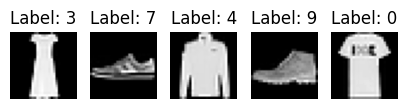

Случайные сэмплы из тестового датасета:


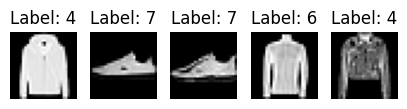

In [8]:
### YOUR CODE HERE
import random

def visualize_samples(dataset, indices):
    """ Визуализация образцов из датасета. """
    fig, axes = plt.subplots(1, len(indices), figsize=(5, 1))
    for idx, ax in zip(indices, axes):
        image, label = dataset[idx]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Выбор случайных элементов набора
num_samples = 5
random_indices_train = random.sample(range(len(train_dataset)), num_samples)
random_indices_test = random.sample(range(len(test_dataset)), num_samples)

# Визуализация образцов из обучающего набора
print("Случайные сэмплы из обучающего датасета:")
visualize_samples(train_dataset, random_indices_train)

# Визуализация образцов из тестового набора
print("Случайные сэмплы из тестового датасета:")
visualize_samples(test_dataset, random_indices_test)

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [9]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        ### YOUR CODE HERE
        if isinstance(sample, np.ndarray):
            # Преобразование массива NumPy в тензор PyTorch
            return torch.from_numpy(sample)
        else:
            raise TypeError("Input should be a numpy.ndarray.")


# SHOULD BE CALLABLE ToTensor(x)

In [10]:
transform = ToTensor()

### YOUR CODE HERE
# init dataset with your transform and check datatype
train_dataset = FashionMnist("data/FashionMNIST/raw", image_transform=transform)
test_dataset = FashionMnist("data/FashionMNIST/raw", train=False, image_transform=transform)

# Проверка типа данных
image, label = train_dataset[0]
assert image.dtype == torch.float32, "Преобразование NumPy не работает корректно"

Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [11]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [12]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [13]:
### YOUR CODE HERE
### WRITE A COLLATE FUNCTION and use it with dataloaders

def collate_fn(batch):
    """ Собирает пакет из отдельных элементов датасета. """
    images, labels = zip(*batch)  # Разбиение пакета на изображения и метки
    images = torch.stack(images, dim=0)  # Объединение всех изображений в один тензор
    labels = torch.tensor(labels, dtype=torch.long)  # Преобразование меток в тензор
    return images, labels

Убедитесть, что все работает корректно.

In [14]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True, collate_fn=collate_fn)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2, shuffle=True, collate_fn=collate_fn)
batch = next(iter(test_dataloader))

In [15]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (3 балла)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [16]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [17]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [18]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):

        ### YOUR CODE HERE
        ### CALCULATE RELU FUNCTION WITH TORCH AND SAVE SOMETHING FOR BACKWARD VIA CTX

        # Применяем функцию ReLU
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):

        ### YOUR CODE HERE
        ### GET SOMETHING FROM FORWARD AND CALCULATE GRADIENT
        # CHECK LECTIONS OR GOOGLE

        # Вычисляем производную функции ReLU
        out, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[out <= 0] = 0
        return grad_input

In [19]:
class ReLU(nn.Module):
    def __init__(self):

        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):

        return self.relu(input)


Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [20]:
torch.manual_seed(0)

x = torch.rand((7,15), requires_grad = True, dtype=torch.double)
relu = ReLU()

assert gradcheck(relu, x)

In [21]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [22]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):

        ### YOUR CODE HERE
        ### CALCULATE OUTPUT
        ### AND SAVE SOMETHING FOR BACKWARD
        ctx.save_for_backward(inp, weight, bias)
        output = inp @ weight.T + bias

        return output

    @staticmethod
    def backward(ctx, grad_output):

        # GET SOMETHING FROM BACKWARD
        inp, weight, bias = ctx.saved_tensors

        # CHECK HOW BACKWARD PERFORMED
        grad_bias = grad_output.sum(0)
        grad_weight = grad_output.T @ inp
        grad_input =  grad_output @ weight


        return grad_input, grad_weight, grad_bias

In [23]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()

        ### YOUR CODE HERE
        ### initialize weights and bias with small random numbers or xavier
        ### do not forget to make them torch.nn.Parameter
        self.weight = nn.Parameter(torch.randn(output_units, input_units, requires_grad=True))
        nn.init.kaiming_uniform_(self.weight, mode='fan_in', nonlinearity='relu')

        self.bias = nn.Parameter(torch.randn(output_units))

        self.linear = LinearFunction.apply

    def forward(self,inp):

        return self.linear(inp, self.weight, self.bias)

    # добавила функцию для вывода входных и выходных характеристик
    def __repr__(self):
        return f"Linear({self.weight.shape[1]}, {self.weight.shape[0]}, bias={self.bias is not None})"

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [24]:
torch.manual_seed(0)

x = torch.rand((6,12), requires_grad = True, dtype=torch.double)
linear = Linear(12, 14).double()

assert gradcheck(linear, x)

Сравнение с `PyTorch`.

In [25]:
output_units = 32
input_units = 15

x = torch.rand((16,15), requires_grad = True, dtype=torch.double)


weight = torch.rand(size=(output_units, input_units), dtype=torch.double)
bias = torch.rand(size=(output_units,), dtype=torch.double)

torch_linear = torch.nn.Linear(input_units, output_units, dtype=torch.double)
our_linear = Linear(input_units, output_units).double()


state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)



torch_forward = torch_linear.forward(x)
our_forward = our_linear(x)
assert torch.allclose(torch_forward, our_forward)

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев. _(Я заменила hidden_layers_size на initial_hidden_size, чтобы количество скрытых слоев варьировалось)_

In [26]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, initial_hidden_size=256, num_layers=5,
                 num_classes=10):
        super().__init__()


        ### YOUR CODE HERE
        ### STACK LAYERS WITH DEFINED PARAMETERS
        ### USE nn.Dropout, your linear, your relu and whatever you like
        ### LAST LAYER SHOULD BE nn.LogSoftmax
        layers = []

        # Проверка, нужны ли скрытые слои
        if num_layers > 1:
            hidden_layers_size = initial_hidden_size

            # Входной слой
            layers.append(Linear(input_size, hidden_layers_size))
            layers.append(ReLU())
            layers.append(nn.Dropout(p=0.25))

            # Скрытые слои
            for i in range(num_layers - 2):
                next_hidden_size = hidden_layers_size // 2  # Уменьшаем размер вдвое
                layers.append(Linear(hidden_layers_size, next_hidden_size))
                layers.append(ReLU())
                layers.append(nn.Dropout(p=0.25))

                hidden_layers_size = next_hidden_size

            # Перед последним слоем
            last_layer_input = hidden_layers_size
        else:
            # Если скрытые слои не используются
            last_layer_input = input_size

        # Выходной слой
        layers.append(Linear(last_layer_input, num_classes))
        layers.append(nn.LogSoftmax(dim=1))

        self.net = nn.Sequential(*layers)

    def forward(self, inp):

        ### YOUR CODE HERE
        ### APPLY YOUR NET TO THE INPUT
        return self.net(inp)

In [27]:
model = Network(num_layers=4)

In [28]:
print(model)

Network(
  (net): Sequential(
    (0): Linear(784, 256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(256, 128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(128, 64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(64, 10, bias=True)
    (10): LogSoftmax(dim=1)
  )
)


Ниже вам предстоит написать цикл обучения. Сначала это бывает больно, но потом уже на автомате делается, в начале так всегда


In [29]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [30]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [31]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    ### YOUR CODE HERE
    ### MOVE MODEL TO DEVICE
    ### CHANGE MODEL TO TRAIN OR EVAL MODE
    model.to(device)
    model.train() if is_train else model.eval()
    context = torch.enable_grad() if is_train else torch.no_grad()

    ### SET LOGGING VALUES
    ### ITERATE OVER DATALOADER
    ### MOVE BATCH AND LABELS TO DEVICE
    ### GET MODEL OUTPUT
    ### GET MODEL PREDICTIONS (from the probabilites)
    ### CALCULATE LOSS
    ### BACKWARD IF TRAIN
    ### STEP WITH OPTIMIZER (DONT FORGET TO ZERO GRAD)
    ### UPDATE LOGGING VALUES WITH LOSS AND ACCURACY
    ### RETURN LOGGED VALUES
    total_loss = 0
    total_accuracy = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.shape[0], -1)
        with context:
            # Прямой проход
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            if is_train:
                # Обратный проход и шаг оптимизации
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy(predictions, labels).item()

    return total_loss / len(loader), total_accuracy / len(loader)

Теперь обучим нашу нейронную сеть. _(Я обернула обучение в функцию, чтобы в дальнейшем сравнивать соответствующие оптимизаторы)_

In [32]:
def trainer(model, optimizer, num_epochs=10):
    # INIT YOUR MODEL
    # CRITERION
    #  AND OPTIMIZER
    # Add device
    criterion = nn.NLLLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # SET NUMBER OF EPOCHS
    # ITERATE OVER NUMBERS OF EPOCH
    # TRAIN AND VALIDATE
    # LOG METRICS FOR TRAIN AND VAL LIKE BELOW. (YOU MAY USE YOUR OWN WAY)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = perform_epoch(model, train_dataloader, criterion, optimizer, device)
        val_loss, val_accuracy = perform_epoch(model, test_dataloader, criterion, None, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        print(f"Epoch {epoch + 1} : Train loss {train_loss:.4f}, Train accuracy {train_accuracy:.4f}")
        print(f"           : Val loss {val_loss:.4f}, Val accuracy {val_accuracy:.4f}")
    return train_losses, val_losses, train_accs, val_accs

Я поэскпериментировала и наилучшие результаты с моими слоями получились, если начинать с __392 скрытых слоев__ на первом слое и затем __в 2 раза уменьшать__ последующие до _5 слоя_, в котором мы получаем метки классов, а потом с помощью LogSoftmax их вероятности. Плюс скорость обучения в оптимизаторе сделала равной 0.0007

In [33]:
# Инициализация модели
model = Network(input_size=28*28, initial_hidden_size=392, num_layers=5, num_classes=10)
print(model)

# Выбор и инициализация оптимизатора
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Запуск обучения с выбранным оптимизатором
train_losses, val_losses, train_accs, val_accs = trainer(model, adam_optimizer, num_epochs=30)

Network(
  (net): Sequential(
    (0): Linear(784, 392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(392, 196, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(196, 98, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(98, 49, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(49, 10, bias=True)
    (13): LogSoftmax(dim=1)
  )
)
Epoch 1 : Train loss 4.2458, Train accuracy 0.4445
           : Val loss 0.8763, Val accuracy 0.6585
Epoch 2 : Train loss 1.0110, Train accuracy 0.6191
           : Val loss 0.6846, Val accuracy 0.7224
Epoch 3 : Train loss 0.8453, Train accuracy 0.6857
           : Val loss 0.6215, Val accuracy 0.7725
Epoch 4 : Train loss 0.7692, Train accuracy 0.7227
           : Val loss 0.6482, Val accuracy 0.7719
Epoch 5 : Train loss 0.7222, Train accuracy 0.7452
           : Val loss 0.5783, Val accuracy 0.8001
Epoch 6 : Train loss 0.6

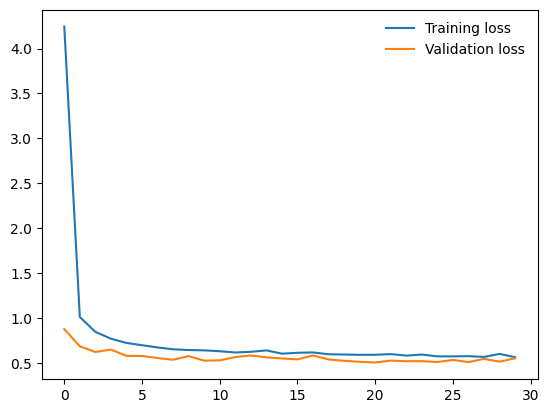

In [34]:
plt.plot(train_losses, label = "Training loss")
plt.plot(val_losses, label = "Validation loss")
plt.legend(frameon = False)

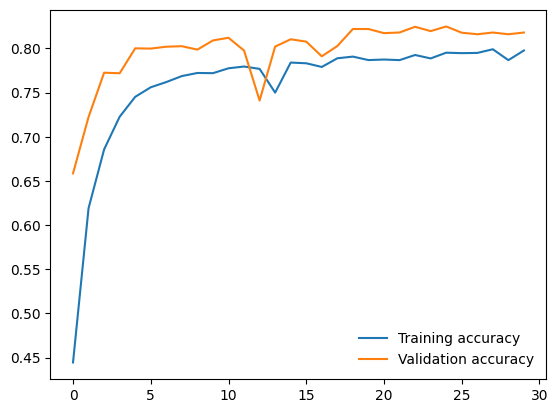

In [35]:
plt.plot(train_accs, label = "Training accuracy")
plt.plot(val_accs, label = "Validation accuracy")
plt.legend(frameon = False)

Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

In [36]:
num_layers_options = range(1, 6)  # Диапазон числа слоев
num_experiments = 3  # Число экспериментов для каждой конфигурации
num_epochs = 5      # Установите необходимое количество эпох

train_accuracies = {num_layers: [] for num_layers in num_layers_options}
val_accuracies = {num_layers: [] for num_layers in num_layers_options}

criterion = nn.NLLLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for num_layers in num_layers_options:
    for experiment in range(num_experiments):
        model = Network(input_size=28*28, initial_hidden_size=392, num_layers=num_layers, num_classes=10)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        epoch_train_acc = []
        epoch_val_acc = []

        print(f"Experiment {experiment + 1} with {num_layers} layers:")
        for epoch in range(num_epochs):
            train_loss, train_accuracy = perform_epoch(model, train_dataloader, criterion, optimizer, device)
            val_loss, val_accuracy = perform_epoch(model, test_dataloader, criterion, None, device)

            epoch_train_acc.append(train_accuracy)
            epoch_val_acc.append(val_accuracy)

            # Выводим результаты после каждой эпохи
            print(f"Epoch {epoch + 1}: Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}")

        train_accuracies[num_layers].append(epoch_train_acc)
        val_accuracies[num_layers].append(epoch_val_acc)

        print("\n")

Experiment 1 with 1 layers:
Epoch 1: Train Acc = 0.7518, Val Acc = 0.7838
Epoch 2: Train Acc = 0.7890, Val Acc = 0.7996
Epoch 3: Train Acc = 0.7959, Val Acc = 0.7976
Epoch 4: Train Acc = 0.8003, Val Acc = 0.7455
Epoch 5: Train Acc = 0.8007, Val Acc = 0.7829


Experiment 2 with 1 layers:
Epoch 1: Train Acc = 0.7497, Val Acc = 0.7443
Epoch 2: Train Acc = 0.7875, Val Acc = 0.8154
Epoch 3: Train Acc = 0.7950, Val Acc = 0.7695
Epoch 4: Train Acc = 0.7988, Val Acc = 0.8095
Epoch 5: Train Acc = 0.8022, Val Acc = 0.7728


Experiment 3 with 1 layers:
Epoch 1: Train Acc = 0.7553, Val Acc = 0.7891
Epoch 2: Train Acc = 0.7886, Val Acc = 0.7650
Epoch 3: Train Acc = 0.7976, Val Acc = 0.7720
Epoch 4: Train Acc = 0.7985, Val Acc = 0.7917
Epoch 5: Train Acc = 0.8026, Val Acc = 0.7267


Experiment 1 with 2 layers:
Epoch 1: Train Acc = 0.6156, Val Acc = 0.6764
Epoch 2: Train Acc = 0.6337, Val Acc = 0.7228
Epoch 3: Train Acc = 0.6568, Val Acc = 0.7408
Epoch 4: Train Acc = 0.6679, Val Acc = 0.7196
Epoch 5:

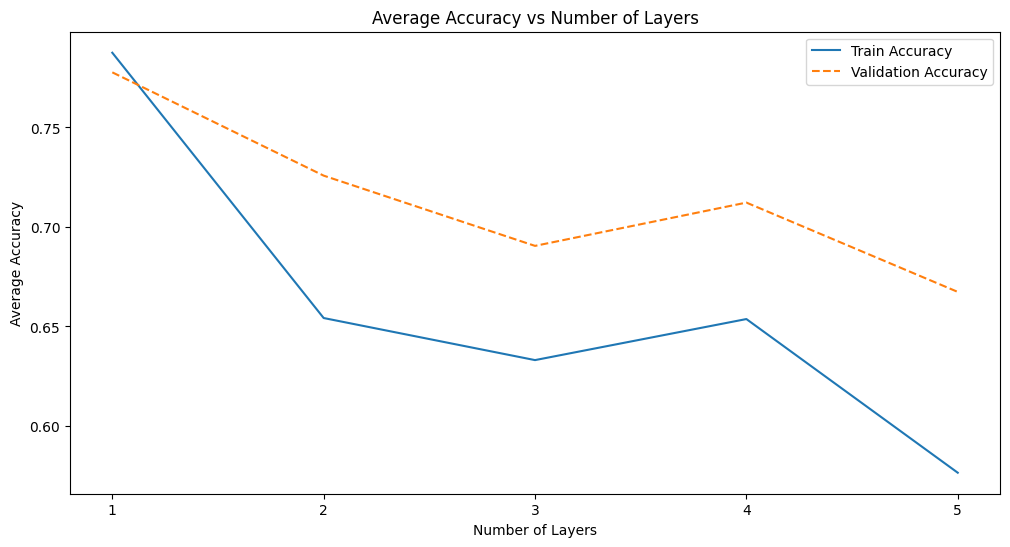

In [37]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

# Списки для средней тренировочной и валидационной точности по слоям
avg_train_accuracies = []
avg_val_accuracies = []

# Рассчитываем среднюю точность для каждого числа слоев
for num_layers in num_layers_options:
    layer_train_acc = [sum(acc) / num_experiments for acc in zip(*train_accuracies[num_layers])]
    layer_val_acc = [sum(acc) / num_experiments for acc in zip(*val_accuracies[num_layers])]

    avg_train_accuracies.append(sum(layer_train_acc) / num_epochs)
    avg_val_accuracies.append(sum(layer_val_acc) / num_epochs)

# Строим графики
plt.plot(num_layers_options, avg_train_accuracies, label='Train Accuracy')
plt.plot(num_layers_options, avg_val_accuracies, label='Validation Accuracy', linestyle='--')

plt.xlabel('Number of Layers')
plt.ylabel('Average Accuracy')
plt.xticks(list(num_layers_options))  # Установим деления на оси X равными числу слоев
plt.legend()
plt.title('Average Accuracy vs Number of Layers')
plt.show()

__Вывод:__ как видно из результатов, простая модель с одним слоем показывает хорошую обобщающую способность, а с увеличением слоев наблюдаются колебания в точности. Однако модели с большим количеством слоев могут показывать лучшую производительность при оптимизации и настройке гиперпараметров (как в случае с моей моделью выше, которая показала точность выше, чем однослойная модель (0.8180 __vs.__ 0.7829)).

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (1 балл).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [38]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

В следующем коде я попробовала реализовать Nesterov Accelerated Gradient (NAG), который является вариацией метода моментума, где корректировка весов учитывает не только текущий градиент, но и направление, в котором градиент будет изменяться.

In [39]:
class NesterovMomentumOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9):
        defaults = dict(lr=lr, momentum=momentum)
        super(NesterovMomentumOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']

            for p in group['params']:
                if p.grad is not None:
                    param_state = self.state[p]

                    # Получаем скорость или инициализируем ее нулем
                    if 'velocity' not in param_state:
                        param_state['velocity'] = torch.clone(p.grad).detach()

                    # Рассчитываем скорость
                    velocity = param_state['velocity']
                    temp = torch.clone(velocity).detach()
                    velocity.mul_(momentum).add_(p.grad, alpha=1)

                    # Шаг вперед с использованием текущего момента, а затем обновляем с учетом нового градиента
                    p.add_(temp, alpha=momentum * -lr)
                    p.add_(p.grad, alpha=-lr)

In [40]:
# Инициализация модели
model = Network(input_size=28*28, initial_hidden_size=256, num_layers=4, num_classes=10)

# Обучение с Adam
print("Training with Adam Optimizer")
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
adam_train_losses, adam_val_losses, adam_train_accs, adam_val_accs = trainer(model, adam_optimizer, num_epochs=10)

# Обучение с Nesterov Momentum Optimizer
print("\nTraining with Nesterov Momentum Optimizer")
nesterov_optimizer = NesterovMomentumOptimizer(model.parameters(), lr=0.001, momentum=0.9)
nesterov_train_losses, nesterov_val_losses, nesterov_train_accs, nesterov_val_accs = trainer(model, nesterov_optimizer, num_epochs=10)

Training with Adam Optimizer
Epoch 1 : Train loss 3.7656, Train accuracy 0.4497
           : Val loss 0.9465, Val accuracy 0.6135
Epoch 2 : Train loss 1.1593, Train accuracy 0.5445
           : Val loss 0.9249, Val accuracy 0.6240
Epoch 3 : Train loss 1.0095, Train accuracy 0.6047
           : Val loss 0.7455, Val accuracy 0.7073
Epoch 4 : Train loss 0.8955, Train accuracy 0.6575
           : Val loss 0.6889, Val accuracy 0.7241
Epoch 5 : Train loss 0.8140, Train accuracy 0.6824
           : Val loss 0.6944, Val accuracy 0.7254
Epoch 6 : Train loss 0.7945, Train accuracy 0.6896
           : Val loss 0.6546, Val accuracy 0.7333
Epoch 7 : Train loss 0.8112, Train accuracy 0.6870
           : Val loss 0.6645, Val accuracy 0.7336
Epoch 8 : Train loss 0.7778, Train accuracy 0.6935
           : Val loss 0.6432, Val accuracy 0.7371
Epoch 9 : Train loss 0.7821, Train accuracy 0.6948
           : Val loss 0.6535, Val accuracy 0.7385
Epoch 10 : Train loss 0.7820, Train accuracy 0.6972
          

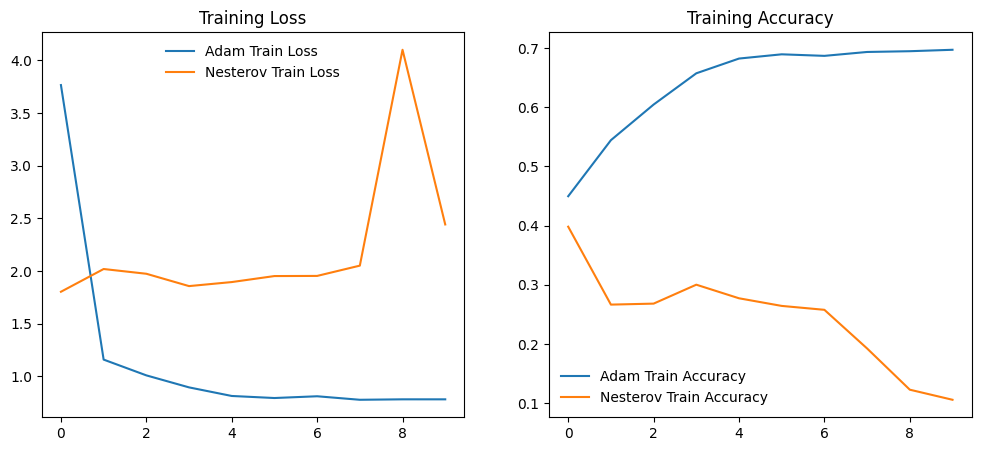

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(adam_train_losses, label='Adam Train Loss')
plt.plot(nesterov_train_losses, label='Nesterov Train Loss')
plt.title('Training Loss')
plt.legend(frameon = False)

plt.subplot(1, 2, 2)
plt.plot(adam_train_accs, label='Adam Train Accuracy')
plt.plot(nesterov_train_accs, label='Nesterov Train Accuracy')
plt.title('Training Accuracy')
plt.legend(frameon = False)

plt.show()

__Вывод:__ оптимизатор Adam показал себя лучше, так как он автоматически корректирует скорость обучения для каждого параметра. А ухудшение производительности при использовании Nesterov Momentum может быть связано с неоптимальной настройкой параметров, подбор которых является отдельной задачей :)

### 4.2 Реализация современной функции активации (1 балл).
Реализуйте одну из современных функций активации. Например, `Hardswish` или `GELU`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.

Функция GELU вычисляется по следующей формуле:

GELU(x) = x * Ф(x), где Ф(x) - это функция нормального распределения (CDF).



In [42]:
class GELUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        sigmoid = 1 / (1 + torch.exp(-1.702 * x))
        return x * sigmoid

    @staticmethod
    def backward(ctx, grad_output):
        x, = ctx.saved_tensors
        sigmoid = 1 / (1 + torch.exp(-1.702 * x))
        d_sigmoid = sigmoid * (1 - sigmoid)
        return grad_output * (sigmoid + 1.702 * x * d_sigmoid)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gelu = GELUFunction.apply

    def forward(self, input):
        return self.gelu(input)

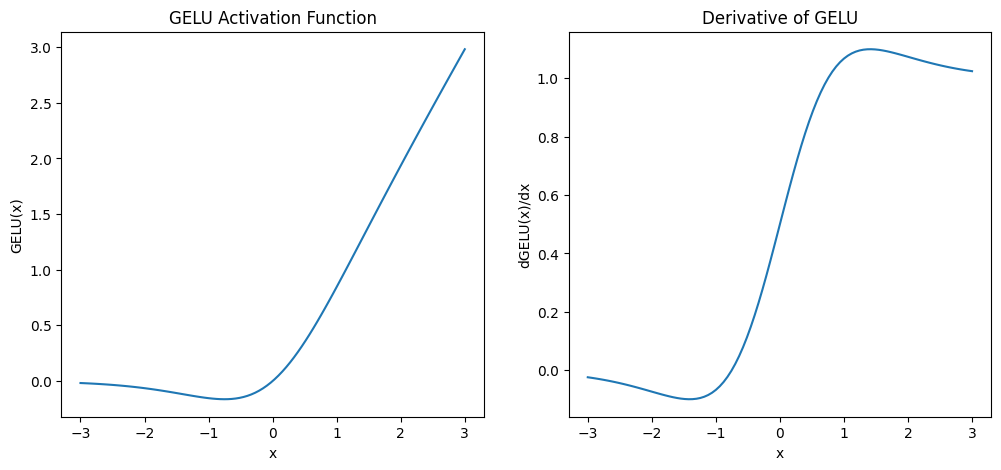

In [43]:
import torch
import matplotlib.pyplot as plt

gelu = GELU()

# Генерация тестовых данных
x = torch.linspace(-3, 3, 100, dtype=torch.float64, requires_grad=True)
y = gelu(x)

# Вычисление производной
y.backward(torch.ones_like(x))
dy = x.grad

# Визуализация функции и её производной
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x.detach().numpy(), y.detach().numpy(), label="GELU")
plt.title("GELU Activation Function")
plt.xlabel("x")
plt.ylabel("GELU(x)")

plt.subplot(1, 2, 2)
plt.plot(x.detach().numpy(), dy.detach().numpy(), label="GELU'")
plt.title("Derivative of GELU")
plt.xlabel("x")
plt.ylabel("dGELU(x)/dx")
plt.show()

In [45]:
# Проверка градиента
test = torch.randn(20, 20, dtype=torch.double, requires_grad=True)
test = test.double()  # gradcheck требует double precision
assert gradcheck(GELUFunction.apply, test, eps=1e-6, atol=1e-4)

In [46]:
class NetworkG(nn.Module):
    def __init__(self, input_size=28*28, initial_hidden_size=256, num_layers=5,
                 num_classes=10):
        super().__init__()


        ### YOUR CODE HERE
        ### STACK LAYERS WITH DEFINED PARAMETERS
        ### USE nn.Dropout, your linear, your relu and whatever you like
        ### LAST LAYER SHOULD BE nn.LogSoftmax
        layers = []

        # Проверка, нужны ли скрытые слои
        if num_layers > 1:
            hidden_layers_size = initial_hidden_size

            # Входной слой
            layers.append(Linear(input_size, hidden_layers_size))
            layers.append(GELU())
            layers.append(nn.Dropout(p=0.25))

            # Скрытые слои
            for i in range(num_layers - 2):
                next_hidden_size = hidden_layers_size // 2  # Уменьшаем размер вдвое
                layers.append(Linear(hidden_layers_size, next_hidden_size))
                layers.append(GELU())
                layers.append(nn.Dropout(p=0.25))

                hidden_layers_size = next_hidden_size

            # Перед последним слоем
            last_layer_input = hidden_layers_size
        else:
            # Если скрытые слои не используются
            last_layer_input = input_size

        # Выходной слой
        layers.append(Linear(last_layer_input, num_classes))
        layers.append(nn.LogSoftmax(dim=1))

        self.net = nn.Sequential(*layers)

    def forward(self, inp):

        ### YOUR CODE HERE
        ### APPLY YOUR NET TO THE INPUT
        return self.net(inp)

In [47]:
# Инициализация модели
model = NetworkG(input_size=28*28, initial_hidden_size=392, num_layers=5, num_classes=10)
print(model)

# Выбор и инициализация оптимизатора
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Запуск обучения с выбранным оптимизатором
train_losses, val_losses, train_accs, val_accs = trainer(model, adam_optimizer, num_epochs=30)

NetworkG(
  (net): Sequential(
    (0): Linear(784, 392, bias=True)
    (1): GELU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(392, 196, bias=True)
    (4): GELU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(196, 98, bias=True)
    (7): GELU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(98, 49, bias=True)
    (10): GELU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(49, 10, bias=True)
    (13): LogSoftmax(dim=1)
  )
)
Epoch 1 : Train loss 4.9288, Train accuracy 0.4057
           : Val loss 0.9958, Val accuracy 0.5758
Epoch 2 : Train loss 1.1760, Train accuracy 0.5395
           : Val loss 0.8664, Val accuracy 0.6238
Epoch 3 : Train loss 1.0084, Train accuracy 0.5926
           : Val loss 0.8269, Val accuracy 0.6399
Epoch 4 : Train loss 0.9061, Train accuracy 0.6424
           : Val loss 0.6738, Val accuracy 0.7237
Epoch 5 : Train loss 0.8261, Train accuracy 0.6776
           : Val loss 0.6903, Val accuracy 0.7163
Epoch 6 : Train loss 0.

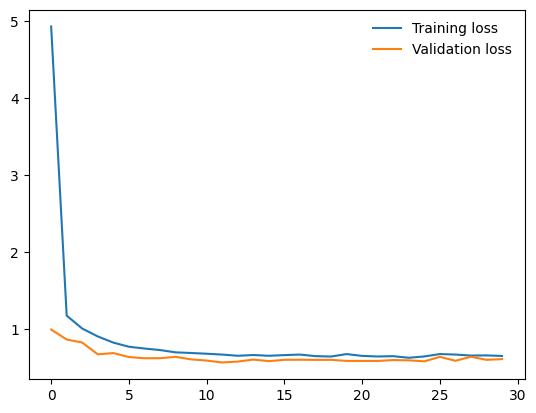

In [48]:
plt.plot(train_losses, label = "Training loss")
plt.plot(val_losses, label = "Validation loss")
plt.legend(frameon = False)

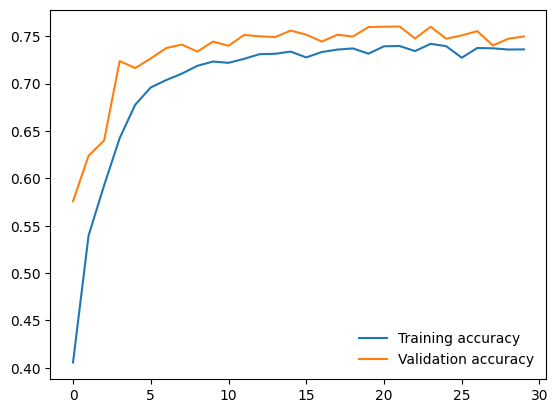

In [49]:
plt.plot(train_accs, label = "Training accuracy")
plt.plot(val_accs, label = "Validation accuracy")
plt.legend(frameon = False)

__Вывод:__ я обучила модель с использованием GELU с теми же настройками, что и с RELU и получила небольшое ухудшение в результатах, но при этом можно сказать, что использование GELU может быть "конкурентноспособным". Все очень зависит от архитектуры модели и настройки гиперпараметров. Те параметры, которые хорошо работают для ReLU, могут быть не такими оптимальными для GELU